In [3]:
from google.colab import drive
import pickle
drive.mount("/content/drive", force_remount=True)

with open('/content/drive/MyDrive/Projet non-alternant/Vidéo/test/test.pkl', "rb") as f:
    X_test, y_test = pickle.load(f)

Mounted at /content/drive


✅ Modèle chargé depuis : /content/drive/MyDrive/Projet non-alternant/Vidéo/old_r2.pth


Évaluation du modèle: 100%|██████████| 221/221 [00:59<00:00,  3.69it/s]



🎯 Résultats sur le test :
   🔸 Test Accuracy : 0.4405
   🔸 Test Loss     : 2.0122


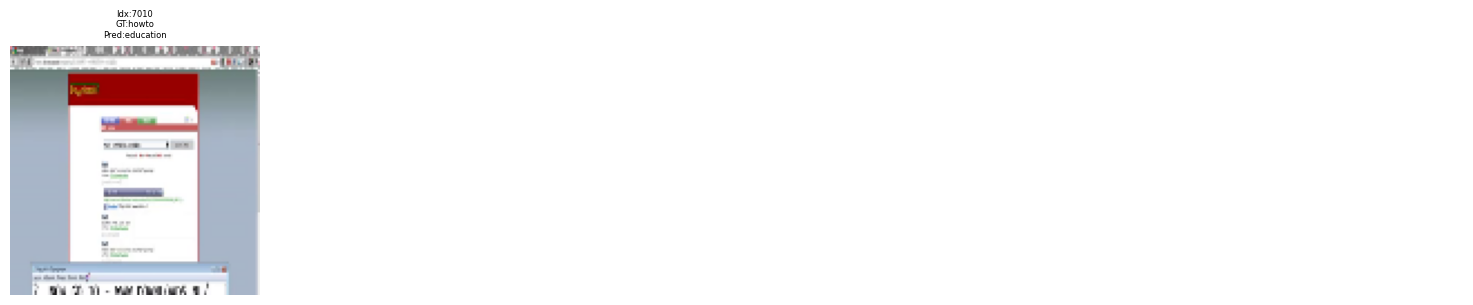

<Figure size 640x480 with 0 Axes>

In [4]:
from google.colab import drive
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
# ============================================================
# 🔹 2. TRANSFORMATIONS
# ============================================================
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                         std=[0.22803, 0.22145, 0.216989]),
])

# ============================================================
# 🔹 3. DATASET DE TEST
# ============================================================
class TestDataset(Dataset):
    def __init__(self, videos, labels, transform=None, target_frames=16):
        self.videos = videos
        self.labels = labels
        self.transform = transform
        self.target_frames = target_frames

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        frames = [cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in self.videos[idx]]

        # Ajustement du nombre d’images
        if len(frames) < self.target_frames:
            repeat_factor = int(np.ceil(self.target_frames / len(frames)))
            frames = (frames * repeat_factor)[:self.target_frames]
        else:
            frames = frames[:self.target_frames]

        if self.transform:
            frames = [self.transform(f) for f in frames]

        video_tensor = torch.stack(frames, dim=1)  # (C, T, H, W)
        return video_tensor, torch.tensor(self.labels[idx], dtype=torch.long)

# ============================================================
# 🔹 4. DÉFINITION DU MODÈLE (même que celui d'entraînement)
# ============================================================
class R2Plus1D_Custom(nn.Module):
    def __init__(self, num_classes=20, dropout_p=0.3):
        super().__init__()
        self.backbone = models.video.r2plus1d_18(
            weights=models.video.R2Plus1D_18_Weights.KINETICS400_V1
        )
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# ============================================================
# 🔹 5. CHARGEMENT DU MODÈLE ENTRAÎNÉ
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/content/drive/MyDrive/Projet non-alternant/Vidéo/old_r2.pth"
model = R2Plus1D_Custom(num_classes=20, dropout_p=0.3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print("✅ Modèle chargé depuis :", model_path)

# ============================================================
# 🔹 6. DATA LOADER DE TEST
# ============================================================
test_dataset = TestDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# ============================================================
# 🔹 7. ÉVALUATION SUR LE TEST
# ============================================================
criterion = nn.CrossEntropyLoss()
running_test_loss = 0.0
correct, total = 0, 0

all_preds, all_labels = [], []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Évaluation du modèle"):
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = running_test_loss / len(test_loader)
test_acc = correct / total

print(f"\n🎯 Résultats sur le test :")
print(f"   🔸 Test Accuracy : {test_acc:.4f}")
print(f"   🔸 Test Loss     : {test_loss:.4f}")

# ============================================================
# 🔹 8. AFFICHAGE DES PRÉDICTIONS (100 premières)
# ============================================================
class_names = {
    0: "music", 1: "people", 2: "gaming", 3: "sports/actions", 4: "news/events/politics",
    5: "education", 6: "tv shows", 7: "movie/comedy", 8: "animation", 9: "vehicles/autos",
    10: "howto", 11: "travel", 12: "science/technology", 13: "animals/pets", 14: "kids/family",
    15: "documentary", 16: "food/drink", 17: "cooking", 18: "beauty/fashion", 19: "advertisement"
}

start_index = 7010  # juste pour l'affichage (optionnel)
n = min(1, len(all_preds))



# Affichage visuel
cols = 5
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

for i in range(n):
    frame = X_test[i][0]  # première image de la vidéo
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video_index = start_index + i
    real_name = class_names[all_labels[i]]
    pred_name = class_names[all_preds[i]]
    axes[i].imshow(frame_rgb)
    axes[i].axis("off")
    axes[i].set_title(f"Idx:{video_index}\nGT:{real_name}\nPred:{pred_name}", fontsize=6)

for j in range(n, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Projet non-alternant/Vidéo/test/ancien_R2.pdf")
plt.show()
# Exemple pour sauvegarder la figure actuelle
plt.tight_layout()



In [ ]:
plt.savefig("/content/drive/MyDrive/Projet non-alternant/Vidéo/test/predictions.pdf")

<Figure size 640x480 with 0 Axes>

/tmp/ipython-input-1956960922.py:26: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


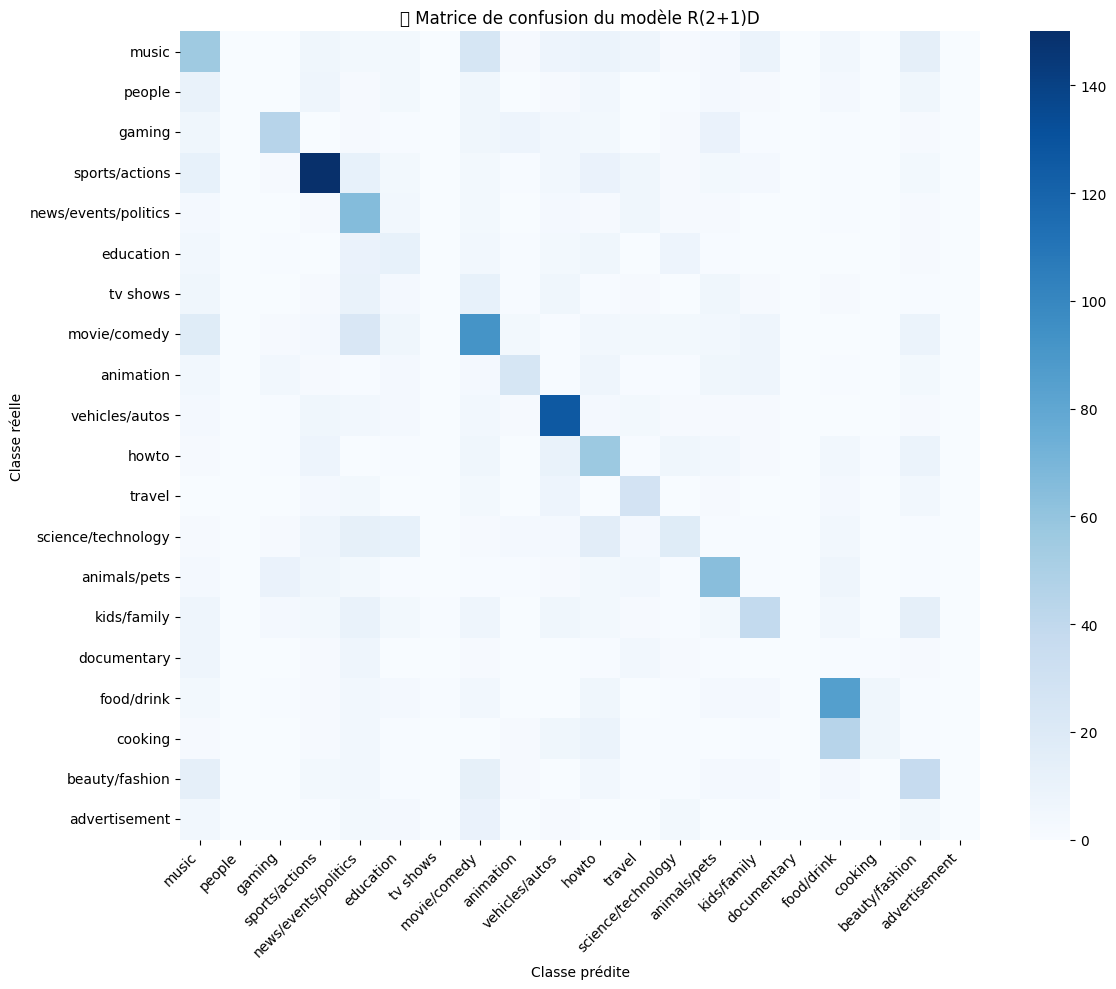


📋 Rapport de classification :

                      precision    recall  f1-score   support

               music       0.33      0.36      0.34       154
              people       0.00      0.00      0.00        52
              gaming       0.62      0.48      0.54        93
      sports/actions       0.69      0.68      0.69       220
news/events/politics       0.34      0.67      0.45        98
           education       0.17      0.22      0.19        55
            tv shows       0.00      0.00      0.00        55
        movie/comedy       0.43      0.50      0.47       183
           animation       0.48      0.35      0.40        72
      vehicles/autos       0.63      0.76      0.69       166
               howto       0.37      0.50      0.42       115
              travel       0.37      0.49      0.42        57
  science/technology       0.31      0.20      0.24        89
        animals/pets       0.51      0.58      0.54       111
         kids/family       0.46      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ============================================================
# 🔹 12. MATRICE DE CONFUSION
# ============================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Calcul de la matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
num_classes = len(class_names)

# Affichage avec seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=False,          # Mets True si tu veux les valeurs dans les cases
    fmt="d",
    cmap="Blues",
    xticklabels=[class_names[i] for i in range(num_classes)],
    yticklabels=[class_names[i] for i in range(num_classes)]
)
plt.title("📉 Matrice de confusion du modèle R(2+1)D")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================
# 🔹 13. (Optionnel) Rapport de classification
# ============================================================
from sklearn.metrics import classification_report

print("\n📋 Rapport de classification :\n")
print(classification_report(all_labels, all_preds, target_names=[class_names[i] for i in range(num_classes)]))
